In [3]:
pip install opencv-python numpy scipy matplotlib

In [6]:
import cv2
import numpy as np
from scipy.linalg import svd
from matplotlib import pyplot as plt
import os

Saving IM1.jpg to IM1 (3).jpg
Saving IM2.jpg to IM2 (3).jpg
Saving IM3.jpg to IM3 (3).jpg
Processing: IM1 (3).jpg


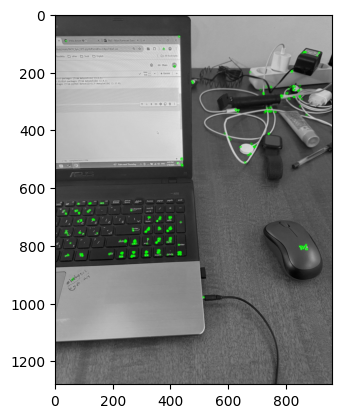

Processing: IM2 (3).jpg


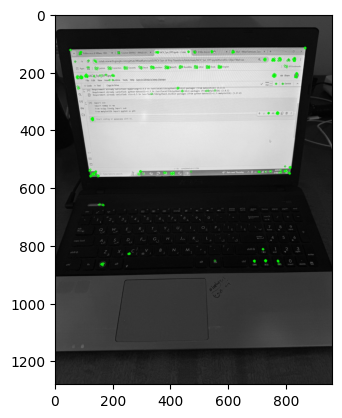

Processing: IM3 (3).jpg


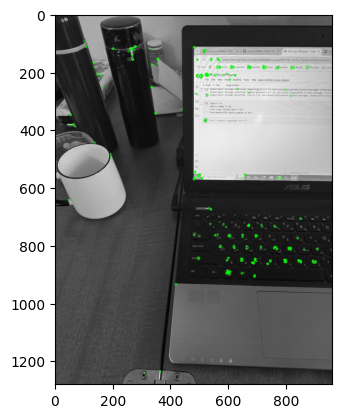

In [17]:
# prompt: Use SIFT (or ORB for faster computation) to detect keypoints and descriptors in images

import cv2
import numpy as np
from scipy.linalg import svd
from matplotlib import pyplot as plt
import os
from google.colab import files
# Use this to upload all images
uploaded = files.upload()

image_paths = list(uploaded.keys())

# Now you can process the images:
for image_path in image_paths:
    try:
      img = cv2.imdecode(np.frombuffer(uploaded[image_path], np.uint8), cv2.IMREAD_COLOR)
      # Now you have the image loaded as 'img'. You can do further operations:
      print(f'Processing: {image_path}')

      # Convert the image to grayscale
      gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Initiate ORB detector
      orb = cv2.ORB_create()

      # find the keypoints and descriptors with ORB
      kp, des = orb.detectAndCompute(gray_image,None)

      # Draw keypoints on the image
      img2 = cv2.drawKeypoints(gray_image,kp,None,color=(0,255,0), flags=0)

      # Display the image with keypoints
      plt.imshow(img2), plt.show()

    except Exception as e:
      print(f'Error processing {image_path}: {e}')

In [ ]:
# prompt: save the uploaded ingaes in the your memory

import cv2
import numpy as np
from scipy.linalg import svd
from matplotlib import pyplot as plt
import os
from google.colab import files

# Install necessary libraries if not already installed
try:
    import cv2
except ImportError:
    print("Installing opencv-python...")
    !pip install opencv-python
    import cv2
try:
    import numpy
except ImportError:
    print("Installing numpy...")
    !pip install numpy
    import numpy
try:
    import scipy
except ImportError:
    print("Installing scipy...")
    !pip install scipy
    import scipy
try:
    import matplotlib
except ImportError:
    print("Installing matplotlib...")
    !pip install matplotlib
    import matplotlib
from matplotlib import pyplot as plt


# Use this to upload all images
uploaded = files.upload()

# Dictionary to store images in memory
images_in_memory = {}

image_paths = list(uploaded.keys())

# Now you can process the images:
for image_path in image_paths:
    try:
        img = cv2.imdecode(np.frombuffer(uploaded[image_path], np.uint8), cv2.IMREAD_COLOR)
        # Store the image in the dictionary using the filename as the key
        images_in_memory[image_path] = img
        print(f'Processing and storing: {image_path}')

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Initiate ORB detector
        orb = cv2.ORB_create()

        # find the keypoints and descriptors with ORB
        kp, des = orb.detectAndCompute(gray_image,None)

        # Draw keypoints on the image
        img2 = cv2.drawKeypoints(gray_image,kp,None,color=(0,255,0), flags=0)

        # Display the image with keypoints
        plt.imshow(img2), plt.show()

    except Exception as e:
        print(f'Error processing {image_path}: {e}')

# Now you can access the images from the 'images_in_memory' dictionary:
# For example, to access the first uploaded image:
# if image_paths:
#     first_image_name = image_paths[0]
#     first_image = images_in_memory.get(first_image_name)
#     if first_image is not None:
#         print("First image shape:", first_image.shape)
#         # Do something with the image...